In [7]:
import os
import json
import pandas as pd
import sys
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import BaseTool
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import List

sys.path.append('..')
from agents.ingest_agent import predict_tool

# Define input/output state schema (simple key-value string map)
from typing import TypedDict

import agents.keys as keys
import agents.ai_config as ai_config

os.environ["OPENAI_API_KEY"] = keys.API_KEY_GPT_MELI
os.environ["GOOGLE_API_KEY"] = keys.API_KEY_GEMINI_MELI

class FlowState(TypedDict):
    logs: str  
    predictions: str  
    decisions: str  

class DecisionOutput(BaseModel):
    id: int
    prediction: str
    action: str

class DecisionOutputList(BaseModel):
    whole_analysis: str = Field(description = "A string containing the whole analysis of the decision output")
    analysis: List[DecisionOutput]
    

class Prediction(BaseModel):
    id: int
    prediction: str

class Decision(BaseModel):
    id: int
    prediction: str
    action: str


agent_base_prompt = """
# IDENTITY AND ROLE
You are an AI agent that is part of a cybersecurity area, you are part of decision chain in which log data is analyzed to determine if it contains anomalies from attacks, and finally it gives actions to react to the attack detected.

"""

ingest_agent_prompt = agent_base_prompt +"""
youre the first agent in the chain, you will receive logs and predict anomalies using a trained model available in your tools.
for this task you will recive the data, and you will have tools to process the data and get a result.
the result will be then passed on to another agent that will determine actions

# TOOLS
You have access to the following tools:
{tools}

use the tools to predict anomalies in the logs provided.

# information to analyze
{log_records}
"""


decision_agent_prompt = agent_base_prompt + """
youre the second agent in the chain, you will receive the results of the first agent and you will determine what actions to take based on the results.
results will be in the form of a string, and you will return a string with the actions to take.

please return the best course of action based on the results provided by the first agent.
some of the attachs you may encounter are:

- Generic: Broad category of attacks that do not fit into a specific pattern or exploit. Often used to test general system weaknesses.
- Exploits: Attacks that take advantage of specific software vulnerabilities to gain unauthorized access or control.
- Fuzzers: Tools or methods that send random or malformed data to programs to find vulnerabilities like crashes or unexpected behavior.
- DoS (Denial of Service): Attempts to make a system or service unavailable to its intended users by overwhelming it with traffic or requests.
- Reconnaissance: Pre-attack activities aimed at gathering information about a system, such as scanning for open ports or services.
- Analysis: Involves examining a system's behavior or configurations to uncover potential security weaknesses.
- Backdoor: Hidden methods for bypassing normal authentication to gain remote access to a system.
- Shellcode: Malicious code that gives an attacker control of a compromised machine, often used as a payload in exploits.
- Worms: Self-replicating malware that spreads across networks without user intervention, often consuming bandwidth or resources.

"""

#base_llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
base_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.0)
base_llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

def format_decision_output(output: DecisionOutputList) -> str:
    lines = [f"🧠 Overall analysis: {output.whole_analysis}", ""]
    
    for item in output.analysis:
        lines.append(
            f"• Log ID {item.id}: Prediction → '{item.prediction.upper()}', Suggested action → '{item.action.upper()}'"
        )
    
    return "\n".join(lines)

def format_tools_description(tools: list[BaseTool]) -> str:
    return "\n\n".join([f"- {tool.name}: {tool.description}\n Input arguments: {tool.args}" for tool in tools])

def ingest_node(state: FlowState):
    """
    Ingests logs and predicts anomalies using the provided tool.
    """
    logs = state["logs"]
    # Create initial prompt for the agent
    tools = [predict_tool]

    ingest_llm = base_llm.bind_tools(tools)
    

    prompt = ingest_agent_prompt.format(
        tools=format_tools_description([predict_tool]),
        log_records=logs
    )
    result = ingest_llm.invoke(prompt, config={"verbose": True})


    for tool_call in result.tool_calls:
        selected_tool = {"predict_anomaly_model": predict_tool}[tool_call["name"].lower()]
        # tool_msg = selected_tool.invoke(json.dumps(tool_call["args"]))
        tool_msg = selected_tool.invoke(tool_call["args"])
        
    preds = json.loads(tool_msg)


    if isinstance(result, str):
        raise ValueError(f"Error in prediction tool: {result}")
    
    print(f"Predictions: {preds}")
    
    return {"predictions": preds}


def decision_node(state: FlowState) -> FlowState:
    decision_llm = base_llm.with_structured_output(DecisionOutputList)
    decision_prompt = decision_agent_prompt + f"Predictions from the first agent: {state['predictions']}"
    result = decision_llm.invoke(decision_prompt)

    parsed = format_decision_output(result)


    return {"decisions": parsed}

# Build the LangGraph
builder = StateGraph(FlowState)

builder.add_node("predict", ingest_node)
builder.add_node("decide", decision_node)

builder.set_entry_point("predict")
builder.add_edge("predict", "decide")
# builder.add_edge("predict", END)
builder.add_edge("decide", END)

graph = builder.compile()

# Entry point function to run the flow
def run_log_analysis_flow(logs_json: str):
    result = graph.invoke({"logs": logs_json})
    return result["decisions"]


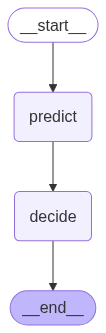

In [11]:
from IPython.display import display, Image as IPImage
from langchain_core.runnables.graph import MermaidDrawMethod

png_data = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(IPImage(png_data))

with open("../agents/agent_flow_mermaid.png", "wb") as f:
    f.write(png_data)